In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if
torch.cuda.is_available() else "cpu")

In [2]:
IMAGE_PATH = '../Dataset/aerial_test/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '../Dataset/aerial_test/dataset/semantic_drone_dataset/label_images_semantic/'

In [3]:
n_classes = 23

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  10


In [4]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1,random_state=19)
X_train, X_val = train_test_split(X_trainval,test_size=0.15, random_state=19)

print('Train Size : ', len(X_train))
print('Val Size : ', len(X_val))
print('Test Size : ', len(X_test))

Train Size :  7
Val Size :  2
Test Size :  1


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


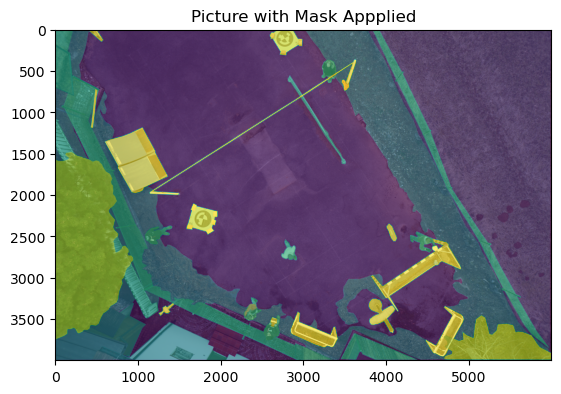

In [5]:
img = Image.open(IMAGE_PATH + df['id'][1] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][1] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [6]:
class DroneDataset(Dataset):
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):
        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches = img_patches.contiguous().view(3,-1, 512,768)

        img_patches = img_patches.permute(1,0,2,3)
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        return img_patches, mask_patches

In [7]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056,interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),A.VerticalFlip(), 
A.GridDistortion(p=0.2),A.RandomBrightnessContrast((0,0.5),(0,0.5)),A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056,interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),

A.GridDistortion(p=0.2)])

In [8]:
#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH,X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val,mean, std, t_val, patch=False)

#dataloader
batch_size= 3

train_loader = DataLoader(train_set,batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [9]:
model = smp.Unet('mobilenet_v2', encoder_weights= 'imagenet', classes=23,
                 activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [10]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output,dim=1), dim=1)

        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) /float(correct.numel())
    
    return accuracy

In [11]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()

            union = torch.logical_or(true_class, true_label).sum().float().item()
            iou = (intersect + smooth) / (union +smooth)
            iou_per_class.append(iou)
            
        return np.nanmean(iou_per_class)

In [12]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [13]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs), "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),"Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)), "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)), "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [15]:
max_lr = 1e-2
epoch = 20
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=max_lr, momentum=0.9,
                            weight_decay=weight_decay)

sched = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion,
              optimizer,sched)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 3.143 
Epoch:1/20.. Train Loss: 3.297.. Val Loss: 3.143.. Train mIoU:0.047.. Val mIoU: 0.046.. Train Acc:0.025.. Val Acc:0.028.. Time: 0.52m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 3.143 >> 3.072 
Epoch:2/20.. Train Loss: 3.256.. Val Loss: 3.072.. Train mIoU:0.060.. Val mIoU: 0.039.. Train Acc:0.031.. Val Acc:0.056.. Time: 0.59m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 3.072 >> 2.787 
Epoch:3/20.. Train Loss: 3.080.. Val Loss: 2.787.. Train mIoU:0.025.. Val mIoU: 0.042.. Train Acc:0.095.. Val Acc:0.331.. Time: 0.50m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 2.787 >> 2.288 
saving model...
Epoch:4/20.. Train Loss: 2.746.. Val Loss: 2.288.. Train mIoU:0.117.. Val mIoU: 0.117.. Train Acc:0.300.. Val Acc:0.662.. Time: 0.47m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 2.288 >> 1.798 
Epoch:5/20.. Train Loss: 2.189.. Val Loss: 1.798.. Train mIoU:289855072.530.. Val mIoU: 1304347826.315.. Train Acc:0.463.. Val Acc:0.674.. Time: 0.46m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.798 >> 1.447 
Epoch:6/20.. Train Loss: 1.972.. Val Loss: 1.447.. Train mIoU:0.127.. Val mIoU: 0.798.. Train Acc:0.464.. Val Acc:0.680.. Time: 0.44m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.447 >> 1.289 
Epoch:7/20.. Train Loss: 2.066.. Val Loss: 1.289.. Train mIoU:0.399.. Val mIoU: 4.054.. Train Acc:0.426.. Val Acc:0.679.. Time: 0.47m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.289 >> 1.281 
Epoch:8/20.. Train Loss: 1.765.. Val Loss: 1.281.. Train mIoU:5652173916.620.. Val mIoU: 8.817.. Train Acc:0.516.. Val Acc:0.677.. Time: 0.44m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:9/20.. Train Loss: 1.997.. Val Loss: 1.295.. Train mIoU:25797101451.312.. Val mIoU: 57826086957.037.. Train Acc:0.511.. Val Acc:0.678.. Time: 0.43m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:10/20.. Train Loss: 1.645.. Val Loss: 1.515.. Train mIoU:8550724641.491.. Val mIoU: 132173913043.994.. Train Acc:0.565.. Val Acc:0.623.. Time: 0.44m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:11/20.. Train Loss: 1.544.. Val Loss: 1.536.. Train mIoU:64927536239.962.. Val mIoU: 377826086957.044.. Train Acc:0.592.. Val Acc:0.620.. Time: 0.47m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.536 >> 1.335 
saving model...
Epoch:12/20.. Train Loss: 1.500.. Val Loss: 1.335.. Train mIoU:386086956521.992.. Val mIoU: 799130434783.136.. Train Acc:0.598.. Val Acc:0.675.. Time: 0.45m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.335 >> 1.282 
Epoch:13/20.. Train Loss: 1.487.. Val Loss: 1.282.. Train mIoU:372028985507.514.. Val mIoU: 136.527.. Train Acc:0.593.. Val Acc:0.686.. Time: 0.47m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:14/20.. Train Loss: 1.727.. Val Loss: 1.296.. Train mIoU:788260869565.665.. Val mIoU: 1593478260870.092.. Train Acc:0.544.. Val Acc:0.684.. Time: 0.45m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.296 >> 1.188 
Epoch:15/20.. Train Loss: 1.407.. Val Loss: 1.188.. Train mIoU:1280724637681.433.. Val mIoU: 1518695652174.442.. Train Acc:0.611.. Val Acc:0.706.. Time: 0.44m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:16/20.. Train Loss: 1.450.. Val Loss: 1.203.. Train mIoU:1470869565217.736.. Val mIoU: 1631304347826.615.. Train Acc:0.576.. Val Acc:0.701.. Time: 0.44m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.203 >> 1.171 
Epoch:17/20.. Train Loss: 1.690.. Val Loss: 1.171.. Train mIoU:2381159420290.246.. Val mIoU: 1331739130435.312.. Train Acc:0.561.. Val Acc:0.710.. Time: 0.46m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:18/20.. Train Loss: 1.419.. Val Loss: 1.187.. Train mIoU:3055652173913.398.. Val mIoU: 1736086956522.268.. Train Acc:0.624.. Val Acc:0.701.. Time: 0.44m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.187 >> 1.177 
Epoch:19/20.. Train Loss: 1.350.. Val Loss: 1.177.. Train mIoU:1688260869565.468.. Val mIoU: 1520434782609.226.. Train Acc:0.646.. Val Acc:0.710.. Time: 0.82m


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loss Decreasing.. 1.177 >> 1.148 
saving model...
Epoch:20/20.. Train Loss: 1.384.. Val Loss: 1.148.. Train mIoU:34757536231884.375.. Val mIoU: 1702608695652.705.. Train Acc:0.644.. Val Acc:0.713.. Time: 0.43m
Total time: 9.65 m


In [16]:
torch.save(model, 'Unet-Mobilenet.pt')

In [17]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU', marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy',marker='*')
    plt.plot(history['val_acc'], label='val_accuracy', marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

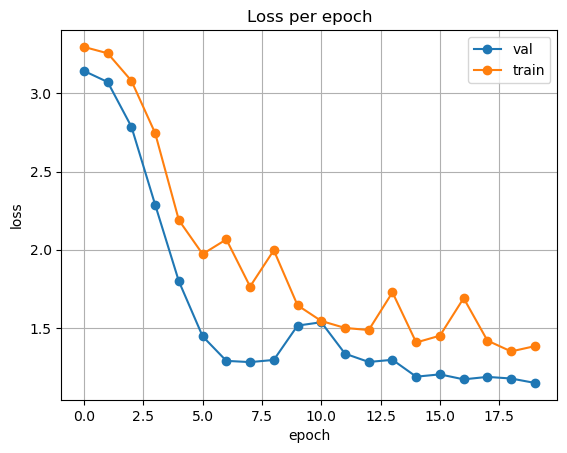

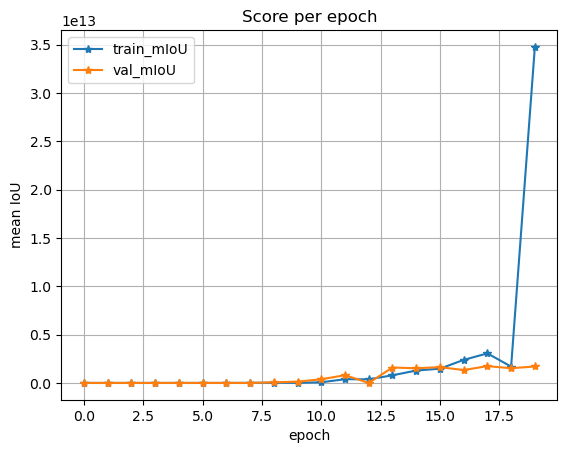

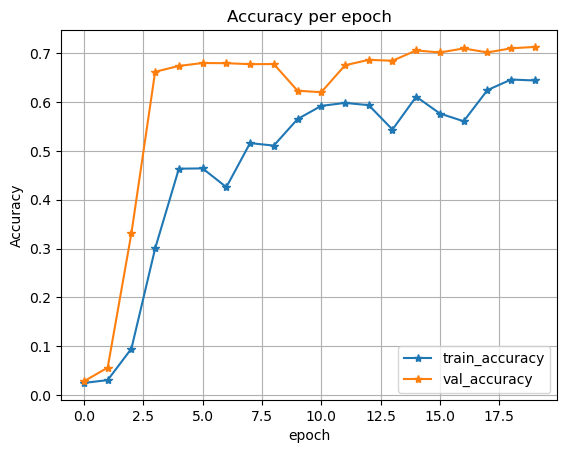

In [18]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [19]:
class DroneTestDataset(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        if self.transform is None:
            img = Image.fromarray(img)
            mask = torch.from_numpy(mask).long()
        return img, mask

In [20]:
t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)

test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH,X_test, transform=t_test)

In [21]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    
    # Convert image and mask to tensors and normalize
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    
    # Convert numpy ndarray mask to tensor
    mask = torch.from_numpy(mask).long()  # Convert mask to a long tensor (for classification tasks)
    
    # Move to the same device as model (e.g., GPU or CPU)
    model.to(device)
    image = image.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():
        # Add batch dimension
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        # Forward pass through the model
        output = model(image)
        
        # Calculate mIoU (Mean Intersection over Union)
        score = mIoU(output, mask)
        
        # Get predicted mask (argmax over classes)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)  # Move to CPU and remove batch dimension
    
    return masked, score

In [22]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    
    # Convert the image to a tensor and normalize
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    
    # Convert the mask to a tensor (long type for classification tasks)
    mask = torch.from_numpy(mask).long()  # Convert numpy mask to long tensor
    
    # Move both image and mask to the correct device (e.g., GPU or CPU)
    image = image.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():
        # Add batch dimension
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        # Forward pass through the model
        output = model(image)
        
        # Calculate pixel accuracy
        acc = pixel_accuracy(output, mask)
        
        # Get the predicted mask
        masked = torch.argmax(output, dim=1)
        
        # Move the result back to the CPU and remove the batch dimension
        masked = masked.cpu().squeeze(0)
    
    return masked, acc

In [23]:
image, mask = test_set[0]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [24]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou
mob_miou = miou_score(model, test_set)

  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy
    
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/1 [00:00<?, ?it/s]

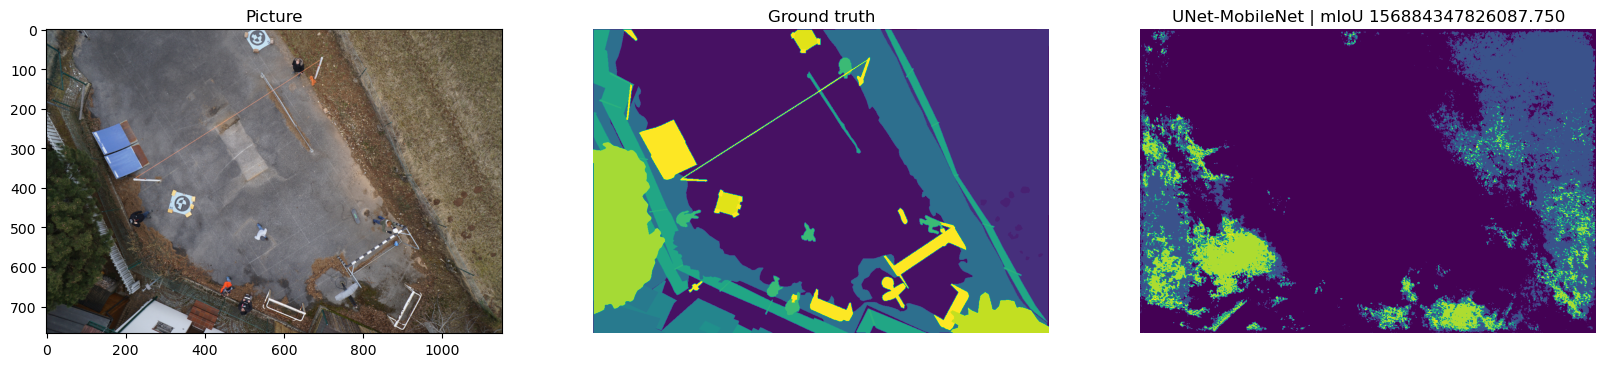

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');
ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()
ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()